#  Introduction
In this blog post, I want to show you a nice complexity metric that works for most major programming languages that we use for our software systems &ndash; the **indentation-based complexity** metric. Adam Tornhill describes this metric in his fabulous book [Software Design X-Rays](https://pragprog.com/book/atevol/software-design-x-rays) on page 25 as follows:
 
> With indentation-based complexity we count the leading tabs and whitespaces
to convert them into logical indentations. ... This works because indentations in code carry meaning. Indentations
are used to increase readability by separating code blocks from each other.

He further says that the trend of the indentation-based complexity in combination with the lines of code metric a good indicator for complexity-growth. If the lines of code don't change but the indentation does, you got a complexity problem in your code.

In this blog post, we are just interested in a static view of the indentation of a code (the evolution of the indentation-based complexity will be discussed in another blog post). I want to show you how you can spot complex areas in your application using the [Pandas data analysis framework](http://pandas.pydata.org/). As application under analysis, I choose the [Linux kernel project](https://github.com/torvalds/linux/) because we want to apply our analysis at big scale.

# The Idea

This analysis works as follows:

1. We search for relevant source code files using `glob`
1. We read in the source code by hacking Pandas' `read_csv()` method
1. We extract the preceding whitespaces/tabs in the code
1. We calculate the ratio between the lines of code of a file and the indentation complexity
1. We spot areas in the Linux kernel that are most complex
1. We visualize the complete result with a treemap

So let's start!

# Analysis
First, let's get all the files with a recursive file search by using `glob`. Because the Linux kernel code is mostly written in the C programming language, we search for the corresponding file endings `.c`  (C program code files) and `.h` (header files).

In [1]:
import glob
file_list = glob.glob("../../linux/**/*.[c|h]", recursive=True)
file_list[:5]

['../../linux\\arch\\alpha\\boot\\bootp.c',
 '../../linux\\arch\\alpha\\boot\\bootpz.c',
 '../../linux\\arch\\alpha\\boot\\main.c',
 '../../linux\\arch\\alpha\\boot\\misc.c',
 '../../linux\\arch\\alpha\\boot\\stdio.c']

## Read in in the content
With the `file_list` at hand, we can now read in the content of the source code files. We could have used a standard Python `with <path> as f` and read in the content with a `f.read()`, but we want to get the data as early into a Pandas' DataFrame (abbreviated "df") to leverage the power of the data analysis framework. 

For each path in our file list, we create a single DataFrame `content_df`. We use a line break `\n` as column separator, ensuring that we create a single row for each source code line. We also specify the `encoding` parameter with the file encoding `latin-1` to make sure that we can read in weird file contents, too (this is totally normal when working in an international team).  We also set `skip_blank_lines` to `False` to keep blank lines. Keeping the blank lines is necessary for debugging purposes (you can inspect certain source code lines with a text editor more easily) as well as for later analysis.

The process of reading in all the source code could take a while for the thousands of files of the Linux kernel. After looping through and reading in all the data, we concatenate all DataFrames with the `concat` method. This gives us a single DataFrame with all source code content for all source code files.

In [2]:
import pandas as pd

content_dfs = []

for path in file_list:
    
    content_df = pd.read_csv(
        path,
        encoding='latin-1',
        sep='\n',
        skip_blank_lines=False,
        names=['line']
    )
    
    content_df['filepath'] = path
    content_dfs.append(content_df)

content = pd.concat(content_dfs)
content.head()

,line,filepath
0,/*,../../linux\arch\alpha\boot\bootp.c
1,* arch/alpha/boot/bootp.c,../../linux\arch\alpha\boot\bootp.c
2,*,../../linux\arch\alpha\boot\bootp.c
3,* Copyright (C) 1997 Jay Estabrook,../../linux\arch\alpha\boot\bootp.c
4,*,../../linux\arch\alpha\boot\bootp.c


Let's see what we've got here in our DataFrame named `content`.

In [3]:
content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22278494 entries, 0 to 266
Data columns (total 2 columns):
line        object
filepath    object
dtypes: object(2)
memory usage: 509.9+ MB


We have over 22 million lines of code (including comments and blank lines) in our DataFrame. Let's clean up that data a little bit.

## Clean the data
We convert `filepath` into a categorical data type to optimize performance and memory consumption. We then get the operating system specific directory separator right and get rid of the superfluous parts of the path.

In [4]:
content['filepath'] = pd.Categorical(content['filepath'])
content['filepath'] = content['filepath']\
    .str.replace("\\", "/")\
    .str.replace("../../linux/", "")
content.head(1)

,line,filepath
0,/*,arch/alpha/boot/bootp.c


We further replace all empty lines with blanks and tabular spaces with a suitable number of whitespaces (we assume here that a tab corresponds to four whitespaces).

In [5]:
content['line'] = content['line'].fillna("")
FOUR_SPACES = " " * 4
content['line'] = content['line'].str.replace("\t", FOUR_SPACES)
content.head(1)

,line,filepath
0,/*,arch/alpha/boot/bootp.c


## Get the measures
Let's get some measures that can help us to spot complex code. We add some additional information to make further analysis and debugging easier: We keep track of the line number of each source code file and create a single continuous index for all source code lines. 

In [6]:
content['line_number'] = content.index + 1
content = content.reset_index(drop=True)
content.head(1)

,line,filepath,line_number
0,/*,arch/alpha/boot/bootp.c,1


Next, we mark comment lines and blank lines. For the identification of the comments, we use a simple heuristic that should be sufficient in most cases.

In [7]:
content['is_comment'] = content['line'].str.match(r'^ *(//|/\*|\*).*')
content['is_empty'] = content['line'].str.replace(" ","").str.len() == 0
content.head(1)

,line,filepath,line_number,is_comment,is_empty
0,/*,arch/alpha/boot/bootp.c,1,True,False


Now we come to the key part: We calculate the indentation for each source code line. An indent is the number of whitespaces that come before the first non-blank character in a line. We just subtract the length from a line without the preceding whitespaces from the length of the whole line.

In [8]:
content['indent'] = content['line'].str.len() - content['line'].str.lstrip().str.len()
content.head(1)

,line,filepath,line_number,is_comment,is_empty,indent
0,/*,arch/alpha/boot/bootp.c,1,True,False,0


## Get the source code
We make sure to only inspect the real source code lines. Because we have the information about the blank lines and comments, we can filter these out very easily. We immediately aggregate the indentations with a `count` to get the number of source code lines as well as the summary of all indents for each `filepath` aka source code file. We also rename the columns of our new DataFrame accordingly.

In [9]:
source_code_content = content[content['is_comment'] | content['is_empty']]
source_code = source_code_content.groupby('filepath')['indent'].agg(['count', 'sum'])
source_code.columns = ['lines', 'indents']
source_code.head()

,lines,indents
filepath,,
Documentation/scheduler/sched-pelt.c,39,58
Documentation/usb/usbdevfs-drop-permissions.c,26,38
arch/alpha/boot/bootp.c,95,201
arch/alpha/boot/bootpz.c,184,334
arch/alpha/boot/main.c,60,67


To get a quick overview of the data we have now, we plot the results in a scatter diagram.

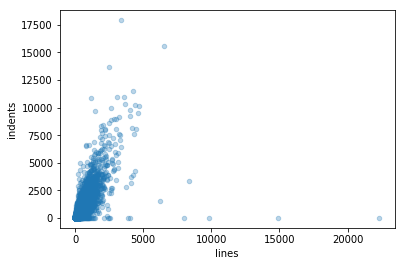

In [10]:
%matplotlib inline
source_code.plot.scatter('lines', 'indents', alpha=0.3);

Alright, we have a very few outliners in both dimensions and a slight correlation between the lines of code and the indentation (who guessed it?). But for now, we leave the outliers where the are.

## Analyze complexity
Let's build the ratio between the indentations and the lines of code to kind of normalize the data. This is the complexity measure that we are using further on.

In [11]:
source_code['complexity'] = source_code['indents'] / source_code['lines']
source_code.head(1)

,lines,indents,complexity
filepath,,,
Documentation/scheduler/sched-pelt.c,39,58,1.487179


So how complex is our code in general? Let's get also an overview of the distribution of the complexity. We use a histogram to visualize this.

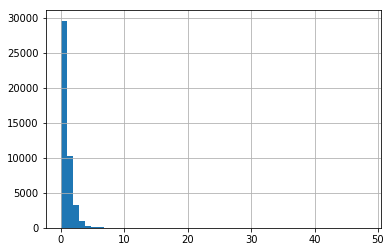

In [12]:
source_code['complexity'].hist(bins=50)

Almost 30,000 files are probably okayish regarding our complexity measure. 

## Complexity per component
Next, we execute an analysis per component to find out where the most complex areas are in the application. For this, we first sum up the metrics for each component. We can identify a component in the Linux kernel roughly by using the first parts of the file path.

In [13]:
source_code['component'] = source_code.index\
    .str.split("/", n=2)\
    .str[:2].str.join(":")
source_code.head(1)

,lines,indents,complexity,component
filepath,,,,
Documentation/scheduler/sched-pelt.c,39,58,1.487179,Documentation:scheduler


We then sum up all our measures per component.

In [14]:
measures_per_component = source_code.groupby('component').sum()
measures_per_component.head()

,lines,indents,complexity
component,,,
Documentation:scheduler,39,58,1.487179
Documentation:usb,26,38,1.461538
arch:alpha,16690,20468,189.999151
arch:arc,7836,10610,114.869605
arch:arm,125156,135452,1563.318216


Last, we print out the TOP 10 most complex parts of the Linux kernel measured by our indents per lines ratio `complexity`.

In [15]:
measures_per_component['complexity'].nlargest(10)

component
drivers:net        3526.370717
drivers:staging    2612.145956
drivers:gpu        2504.533202
drivers:media      1946.165103
arch:arm           1563.318216
include:linux      1549.853606
arch:mips          1370.794157
arch:powerpc       1168.349146
arch:x86           1047.736624
drivers:scsi        967.622213
Name: complexity, dtype: float64

# Visualization
Finally, we plot our the complexity per component with a treemap. We use the Python visualization library `pygal` (http://www.pygal.org) which is very easy to use and just fits our use case perfectly. As size for the treemap's rectangles, we use the lines of code of the components. As color, we choose red and visualize with the help of the red color's alpha level (aka normalized complexity `comp_norm` between 0 and 1), how red a rectangle of the treemap should be. 

This gives us a  treemap with the following properties:
* The bigger the component/rectangle, the more lines of code.
* The redder you'll see a rectangle, the more complex is a component.

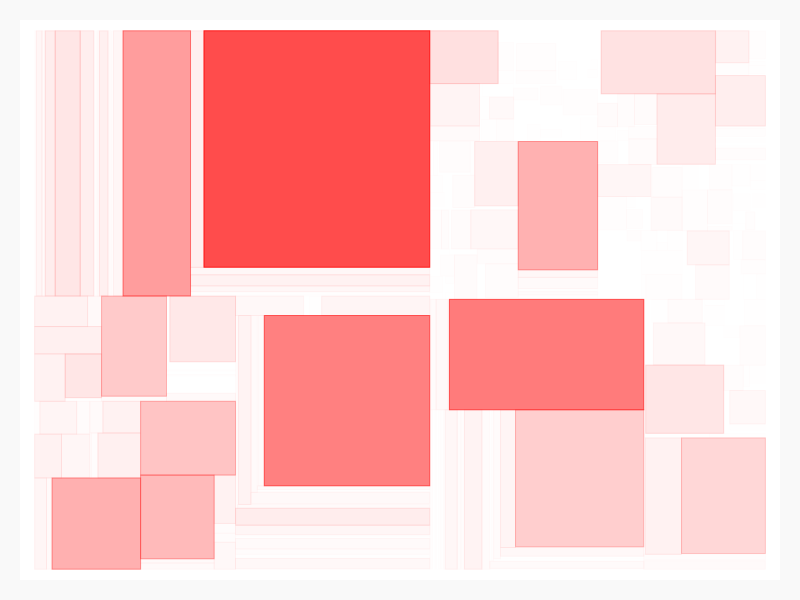

In [16]:
import pygal
config = pygal.Config(show_legend=False)
treemap = pygal.Treemap(config)

max_comp = measures_per_component['complexity'].max()

for row in measures_per_component.iterrows():
    
    filename = row[0]
    entry = row[1]
    comp_norm = entry['complexity'] / max_comp
    
    data = {}
    data['value'] = entry['lines']
    data['color'] = 'rgba(255,0,0,' + str(comp_norm) + ')'
    treemap.add(filename, [data])
    
treemap

There is also an [interactive treemap](https://feststelltaste.github.io/software-analytics/notebooks/vis/indentation_complexity/linux.html) where you can interact with the graphic. But beware: It's almost a megabyte big!

# Conclusion
In this blog post, I showed you how we can obtain an almost programming language agnostic measure for complexity by measuring the indentation of source code. We also spotted the TOP 10 most complex components and visualized the completed results as a treemap.

All this was relatively easy and straightforward to do by using standard Data Science tooling. I hope you liked it and I would be happy, if you could provide some feedback in the comment section.